In [117]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm
import healpy as hp
from tqdm import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/scratch/sm8

In [119]:
plt.rcParams.update({"text.usetex": False})


## Basline analysis

In [120]:
import sbi.utils as utils
import mlflow

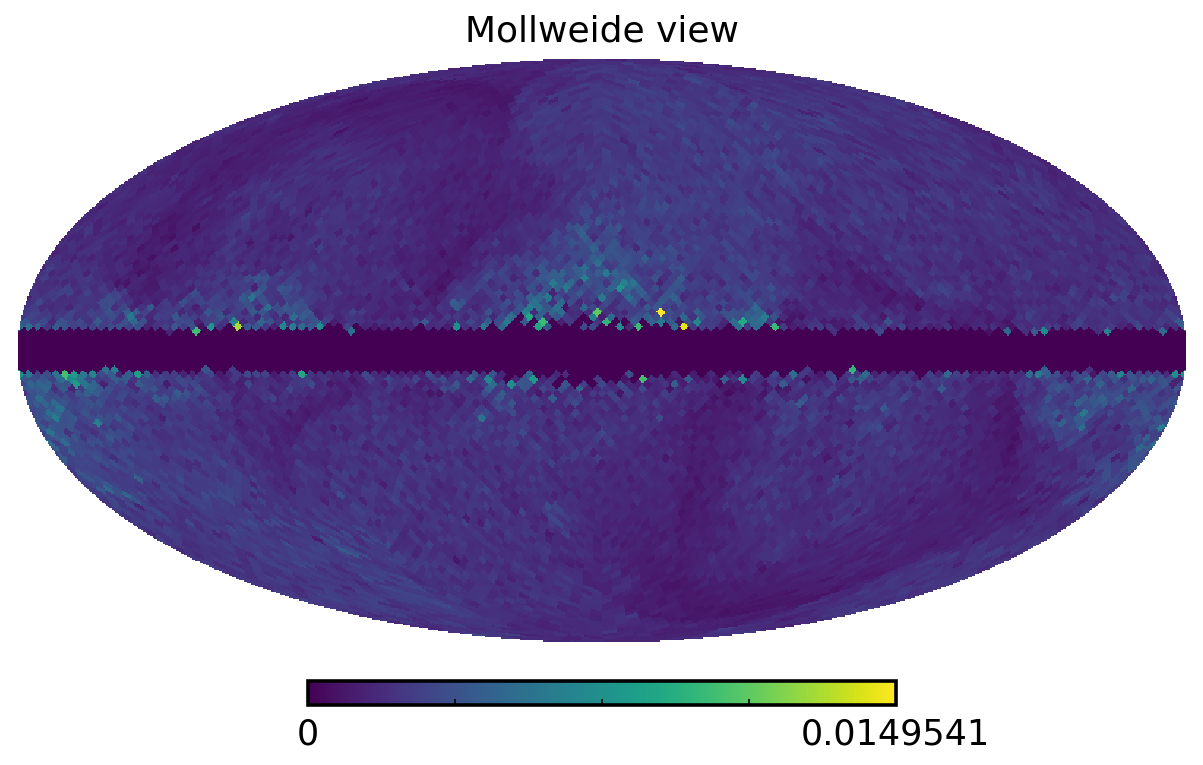

In [126]:
run_id = 'c99de83f200a4617b8dd857af9f6c976'
    
data_dir = '/scratch/sm8383/neural-global-astrometry/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator_anisotropic = mlflow.pytorch.load_model(data_dir + '/logs/mlruns/3/' + run_id + '/artifacts/density_estimator')

sigma_noise_model = list(density_estimator_anisotropic.children())[0].add_noise.sigma
hp.mollview(sigma_noise_model[0][0].cpu().numpy(), nest=True)

In [127]:
run_id = 'f00c10126eac4c31a6ccc9ec4836df27'
    
data_dir = '/scratch/sm8383/neural-global-astrometry/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model(data_dir + '/logs/mlruns/2/' + run_id + '/artifacts/density_estimator')

In [128]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [129]:
mask_roi = (sigma_noise_model[0,0].cpu() == 0).numpy()
mask_roi = torch.Tensor((mask_roi)).bool()

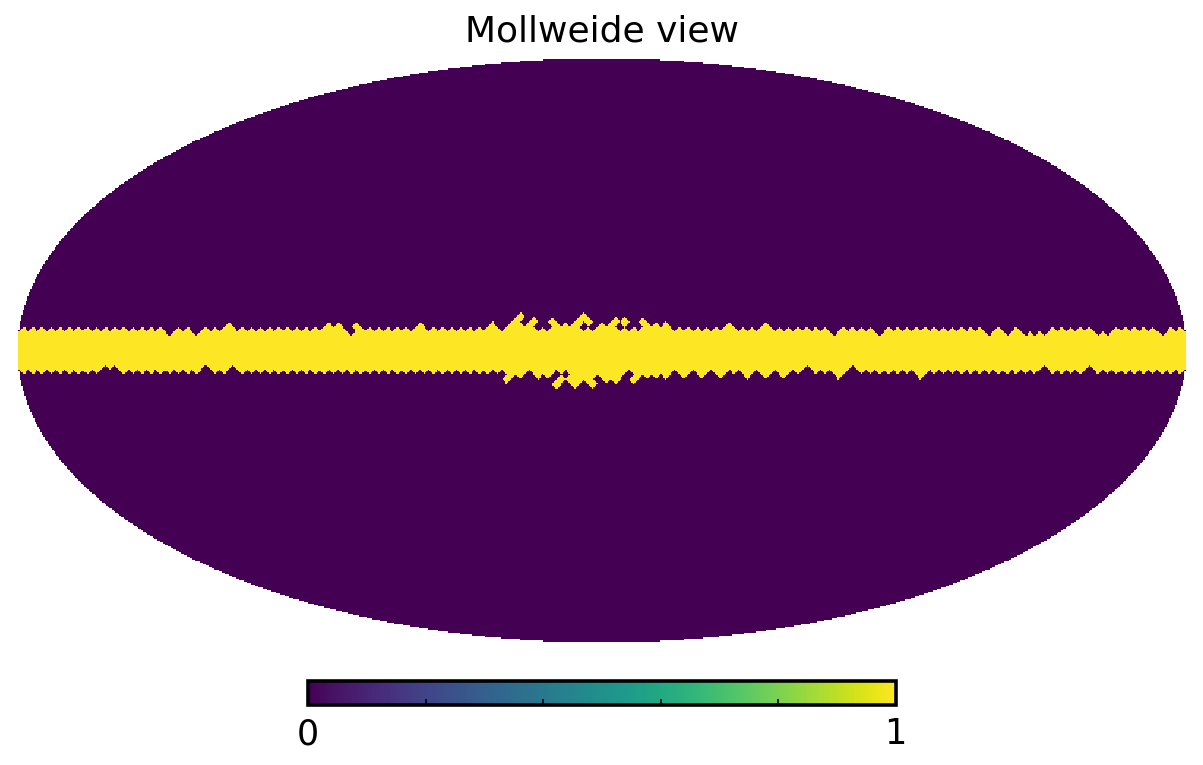

In [130]:
hp.mollview(mask_roi, nest=True)

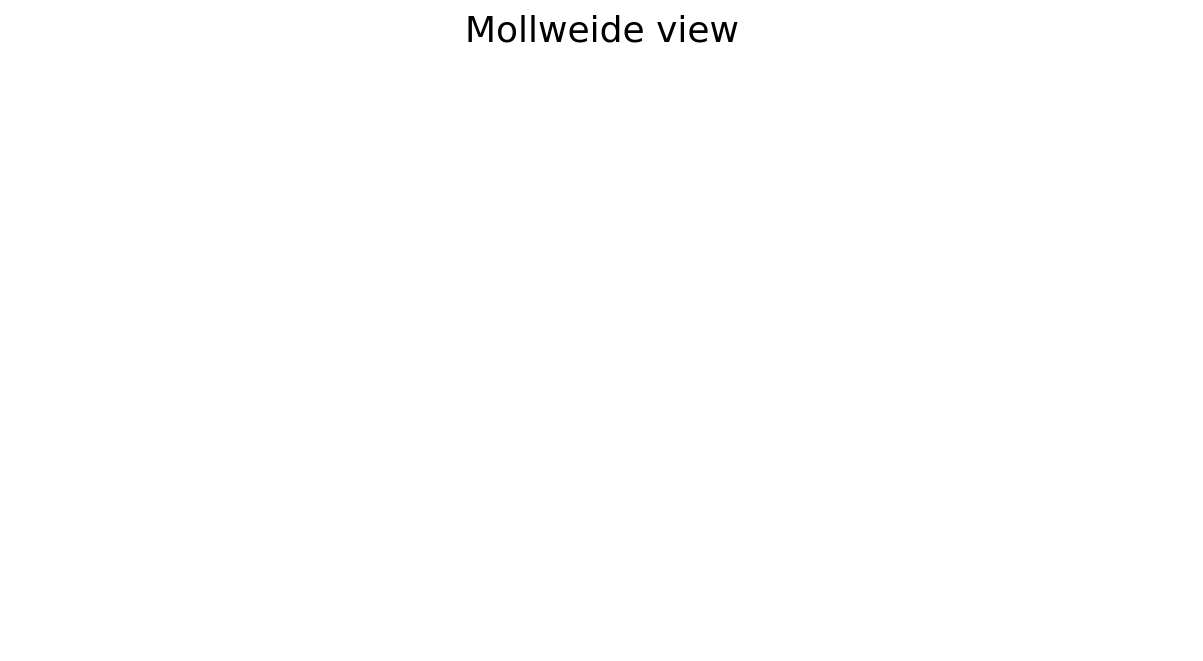

In [134]:
hp.mollview(list(density_estimator.children())[0].embedding_net_y.mask, nest=True)

In [135]:
list(density_estimator.children())[0].add_noise.sigma

0.0023

In [136]:
list(density_estimator.children())[0].add_noise.sigma = 0.
list(density_estimator_anisotropic.children())[0].add_noise.sigma = 0.

In [137]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        x = x.to(device)
#         self.sigma = self.sigma.to(device)
        sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
        x = x + sampled_noise
        return x 

In [138]:
device = 'cuda'

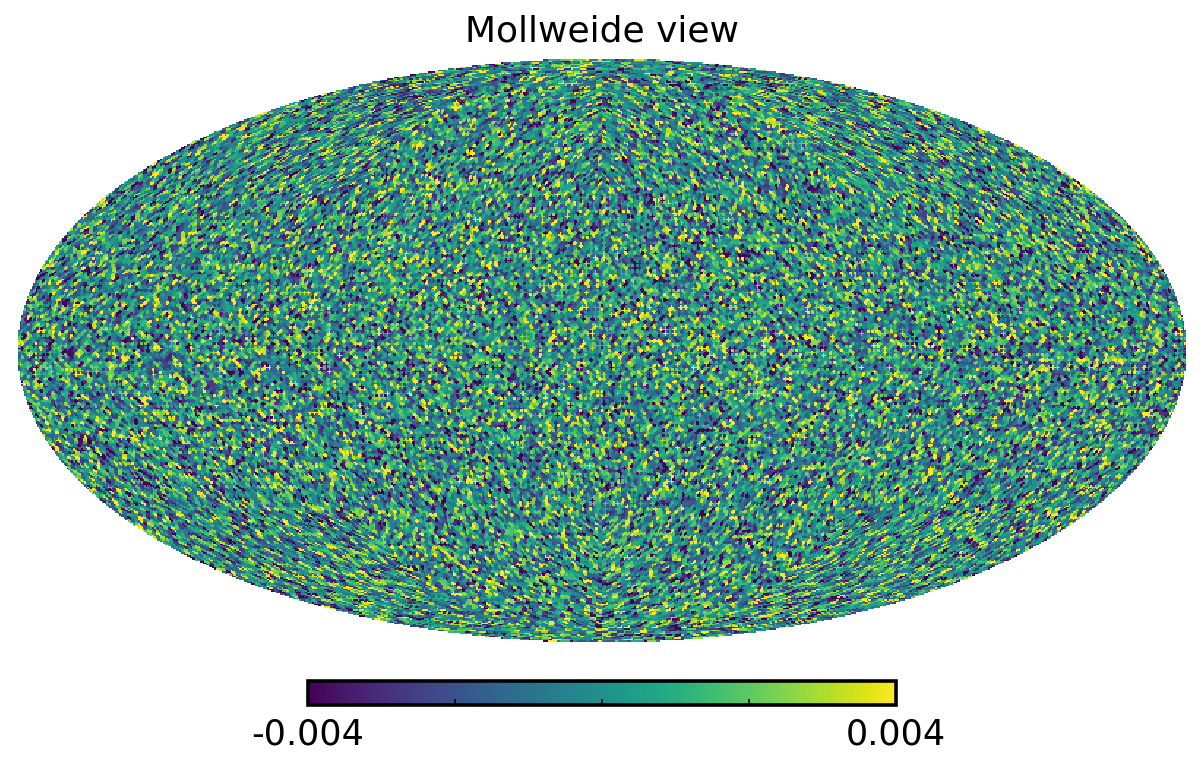

In [139]:
x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_150_{}.npy".format(i))) for i in range(20)]
x_test = torch.cat(x_test, axis=0)
# x_test = torch.zeros_like(x_test)

gn = GaussianNoise(sigma=0.0023).to(device)
x_test = gn(x_test.to(device))

hp.mollview(x_test.cpu().numpy()[0][0], nest=True, min=-0.004, max=0.004)

In [140]:
n_trials = x_test.shape[0]  # Number of samples to simulate
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean = np.mean(out, axis=0)
out_mean -= np.max(out_mean)

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


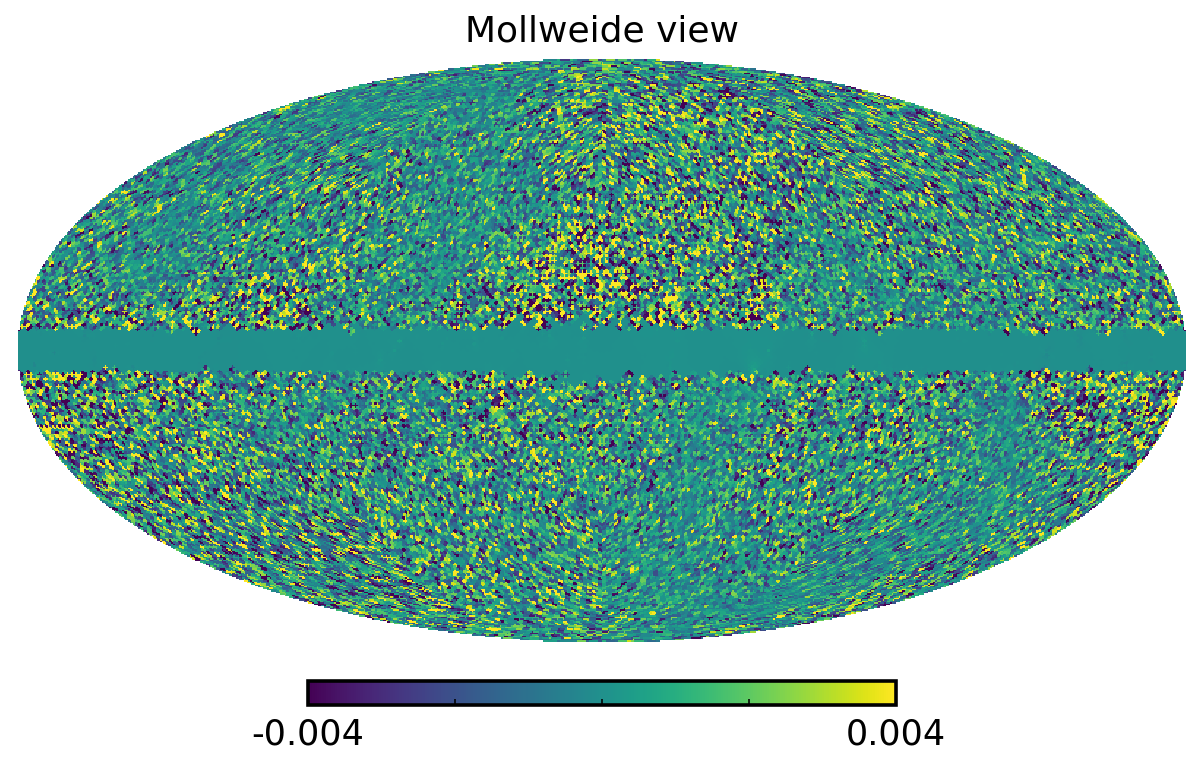

In [141]:
x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_150_{}.npy".format(i))) for i in range(20)]
x_test = torch.cat(x_test, axis=0)
# x_test = torch.zeros_like(x_test)

gn = GaussianNoise(sigma=sigma_noise_model.to(device)).to(device)
x_test = gn(x_test.to(device))

hp.mollview(x_test.cpu().numpy()[0][0], nest=True, min=-0.004, max=0.004)

n_trials = x_test.shape[0]  # Number of samples to simulate
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean_anistropic = np.mean(out, axis=0)
out_mean_anistropic -= np.max(out_mean_anistropic)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator_anisotropic.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean_anistropic_anisotropic = np.mean(out, axis=0)
out_mean_anistropic_anisotropic -= np.max(out_mean_anistropic_anisotropic)

In [27]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

In [143]:
np.save("../data/plot_arrays/sigma_noise_model.npy", sigma_noise_model.cpu().numpy())
np.save("../data/plot_arrays/theta_test.npy", theta_test)
np.save("../data/plot_arrays/out_mean.npy", out_mean)
np.save("../data/plot_arrays/out_mean_anistropic.npy", out_mean_anistropic)
np.save("../data/plot_arrays/out_mean_anistropic_anisotropic.npy", out_mean_anistropic_anisotropic)

In [144]:
sigma_noise_model = np.load("../data/plot_arrays/sigma_noise_model.npy")
theta_test = np.load("../data/plot_arrays/theta_test.npy")
out_mean = np.load("../data/plot_arrays/out_mean.npy")
out_mean_anistropic = np.load("../data/plot_arrays/out_mean_anistropic.npy")
out_mean_anistropic_anisotropic = np.load("../data/plot_arrays/out_mean_anistropic_anisotropic.npy")

In [145]:
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [146]:
plt.rcParams.update({"text.usetex": False})

/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/visufunc.py:317: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  pylab.draw()
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 360 deg 0.00'.
  vdeg, varcmin
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:666: UserWarn

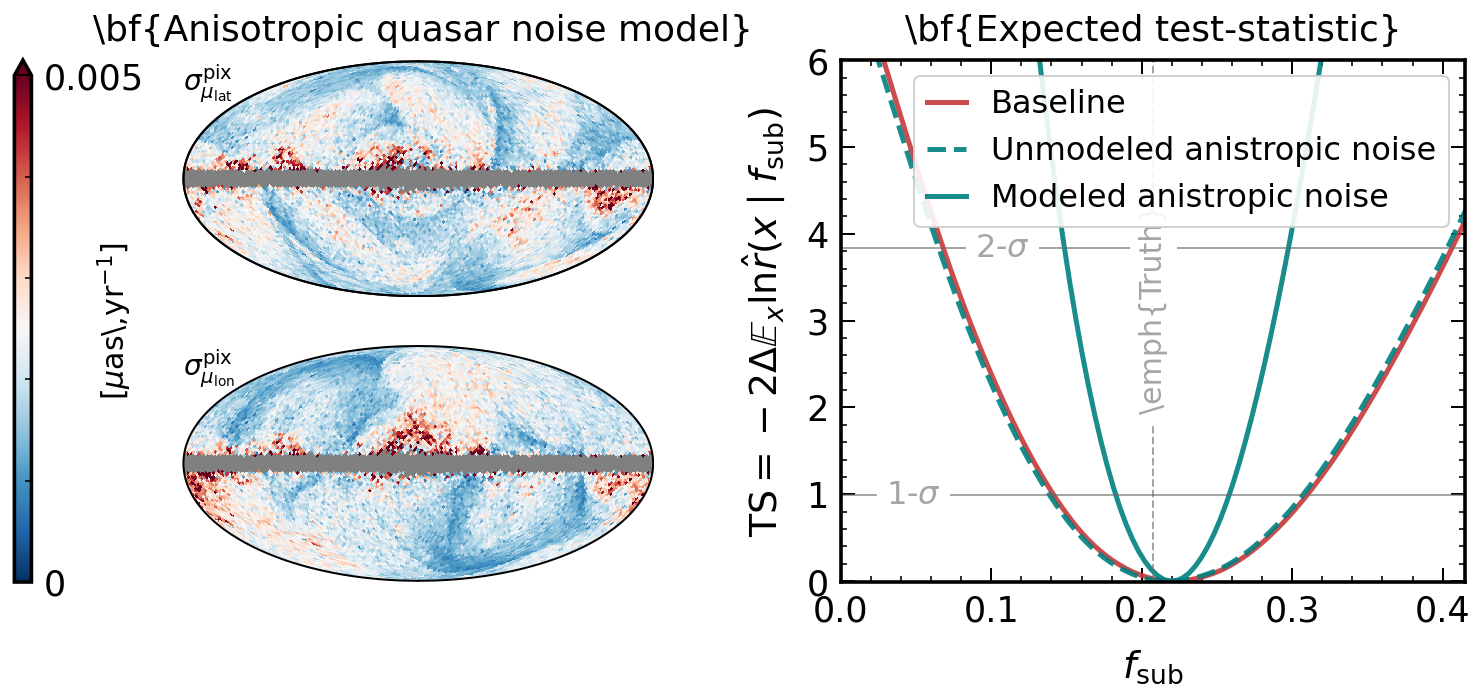

In [148]:
cbar_max = 0.005
cmap = cm.RdBu_r

fig = plt.figure(constrained_layout=True, figsize=(13., 4.8))
gs = fig.add_gridspec(2, 3, height_ratios=(1,1), width_ratios=(0.03, 1., 1.1))

ax1 = fig.add_subplot(gs[0, 1])
the_map = hp.ma(sigma_noise_model[0][1])
the_map.mask = (sigma_noise_model[0][1] == 0) + 0.
hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=None)
hp.graticule(dmer=360,dpar=360,alpha=0)

f = plt.gcf()
hax1 = f.get_axes()[0]
hax1.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lat}}^\mathrm{pix}$", fontsize=14)

ax2 = fig.add_subplot(gs[1, 1])
the_map = hp.ma(sigma_noise_model[0][0])
the_map.mask = (sigma_noise_model[0][0] == 0) + 0.
hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=None, unit=r"$\sigma_{\mu_\mathrm{lon}}$")
hp.graticule(dmer=360,dpar=360,alpha=0)

f = plt.gcf()
hax2 = f.get_axes()[1]
hax2.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lon}}^\mathrm{pix}$", fontsize=14)

fig_cb = plt.gcf()
ax_cb = plt.gca()
image = ax_cb.get_images()[0]

ax4 = fig.add_subplot(gs[:, 0])
cbar = plt.colorbar(image, cax=ax4, orientation='vertical', ticks=[0, cbar_max], extend='max', extendfrac=0.03, alpha=0.3)
cbar.set_label(label=r"[$\mu$as\,yr$^{-1}$]", labelpad=-24, fontsize=15)
# cbar.ax.set_xticklabels(['0', '0.005']) 
cbar.ax.set_yticklabels(['0', '0.005']) 

ax3 = fig.add_subplot(gs[:, 2])

theta_multiplier = (f_sub_fid / 150)

ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean, color=cols_default[0], label="Baseline")
ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic, color='teal', ls='--', label="Unmodeled anistropic noise")
ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic_anisotropic, color='teal', label="Modeled anistropic noise")

ax3.axhline(chi2.isf(1 - .95, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax3.text(f_sub_fid / 3 + 0.02, chi2.isf(1 - .95, 1), r"2-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.axhline(chi2.isf(1 - .68, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax3.text(0.03, chi2.isf(1 - .68, 1), r"1-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.axvline(f_sub_fid, color='dimgrey', lw=1, ls='--', alpha=0.6)
t = ax3.text(f_sub_fid, 2, r"\emph{Truth}", rotation=90, horizontalalignment='center', fontsize=15, color='dimgrey', alpha=0.6)
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.set_ylim(-0.01, 6)
ax3.set_xlim(0.0, 0.415)

ax3.set_xlabel(r"$f_\mathrm{sub}$")
ax3.set_ylabel(r"$\mathrm{TS}  = -2 \Delta \mathbb{E}_x\ln \hat r(x\mid f_\mathrm{sub}) $")

ax3.set_title(r"\bf{Expected test-statistic}", y=1.008)

ax3.legend(loc='upper right', frameon=True, framealpha=0.9, handlelength=1.2, fontsize=16)

ax4.set_title(r"\bf{Anisotropic quasar noise model}", x=24, y=1.008)  # Alternative 1)

# plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
# plt.savefig("../paper/journal-response-v1/anisotropic_noise.pdf", bbox_inches='tight', pad_inches=0.05)


In [199]:
# cbar_max = 0.005
# cmap = cm.RdBu_r

# fig = plt.figure(constrained_layout=True, figsize=(10.2, 5))
# gs = fig.add_gridspec(3, 2, height_ratios=(1,1,0.08), width_ratios=(1.2, 1.))

# ax1 = fig.add_subplot(gs[0, 0])
# the_map = hp.ma(sigma_noise_model[0][1])
# the_map.mask = (sigma_noise_model[0][1] == 0) + 0.
# hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=r"\bf{Anisotropic quasar noise model}")
# hp.graticule(dmer=360,dpar=360,alpha=0)

# f = plt.gcf()
# hax1 = f.get_axes()[0]
# hax1.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lat}}^\mathrm{pix}$", fontsize=14)

# ax2 = fig.add_subplot(gs[1, 0])
# the_map = hp.ma(sigma_noise_model[0][0])
# the_map.mask = (sigma_noise_model[0][0] == 0) + 0.
# hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=None, unit=r"$\sigma_{\mu_\mathrm{lon}}$")
# hp.graticule(dmer=360,dpar=360,alpha=0)

# f = plt.gcf()
# hax2 = f.get_axes()[1]
# hax2.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lon}}^\mathrm{pix}$", fontsize=14)

# fig_cb = plt.gcf()
# ax_cb = plt.gca()
# image = ax_cb.get_images()[0]

# ax4 = fig.add_subplot(gs[2, 0])
# cbar = plt.colorbar(image, cax=ax4, orientation='horizontal', ticks=[0, cbar_max], extend='max', extendfrac=0.03, fraction=0.046, pad=0.04, alpha=0.5)
# cbar.set_label(label=r"$\sigma_\mu^\mathrm{pix}$\,[$\mu$as\,yr$^{-1}$]", labelpad=-4, fontsize=15)
# cbar.ax.set_xticklabels(['0', '0.005']) 

# ax3 = fig.add_subplot(gs[:, 1])

# theta_multiplier = (f_sub_fid / 150)

# ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean, color=cols_default[0], label="Baseline")
# ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic, color='teal', label="Unmodeled anistropic noise")
# ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic_anisotropic, color='teal', ls='--', label="Modeled anistropic noise")

# ax3.axhline(chi2.isf(1 - .95, 1), color='dimgrey', alpha=0.6, lw=1)
# t = ax3.text(f_sub_fid / 3 + 0.02, chi2.isf(1 - .95, 1), r"2-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
# t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

# ax3.axhline(chi2.isf(1 - .68, 1), color='dimgrey', alpha=0.6, lw=1)
# t = ax3.text(0.03, chi2.isf(1 - .68, 1), r"1-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
# t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

# ax3.axvline(f_sub_fid, color='dimgrey', lw=1, ls='--', alpha=0.6)
# t = ax3.text(f_sub_fid, 2, r"\emph{Truth}", rotation=90, horizontalalignment='center', fontsize=15, color='dimgrey', alpha=0.6)
# t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

# ax3.set_ylim(-0.01, 6)
# ax3.set_xlim(0.0, 0.415)

# ax3.set_xlabel(r"$f_\mathrm{sub}$")
# ax3.set_ylabel(r"$\mathrm{TS}  = -2 \Delta \mathbb{E}_x\ln \hat r(x\mid f_\mathrm{sub}) $")

# ax3.set_title(r"\bf{Expected test-statistic}", y=1.008)

# ax3.legend(loc='upper left', frameon=True, framealpha=0.9, handlelength=1.2, fontsize=16)

# # plt.tight_layout()
# fig.subplots_adjust(wspace=0.3)
# plt.savefig("../paper/journal-response-v1/anisotropic_noise.pdf", bbox_inches='tight', pad_inches=0.05)
